# Movie Name Generator

**Import the necessary libraries**

In [1]:
import random
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

**Check if GPU and CUDA are available** 

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU found')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using device: cuda


### **Data preparation**
**Read the dataset**

In [3]:
# Path to your CSV file
file_path = 'netflix_titles.csv'

# Read the CSV file
df = pd.read_csv(file_path)

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


**Extract and preprocess the data**

In [4]:
# Get the titles
titles = df['title'].values

# Regular expression to match titles with only alphabetic characters and spaces
pattern = re.compile(r'^[a-zA-Z\s]+$')

# Lowercase and add a period at the end of each valid title
new_titles = []
for title in titles:
    if pattern.match(str(title)):
        title = str(title).replace('\t', ' ')
        title = str(title).replace('\xa0', '')        
        new_titles.append(str(title).lower() + '.')

# Remove duplicates
dataset = list(set(new_titles))
print(f"Number of movie titles: {len(dataset)}")
print(dataset[:5])

Number of movie titles: 5976
['cloudburst.', 'rivaaz.', 'pee mak.', 'teenage mutant ninja turtles.', 'rainbow time.']


**Character tokenization**

In [5]:
# Get the unique characters in the dataset
chars = sorted(list(set(''.join(dataset))))

# save the characters in a dictionary
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{0: ' ', 1: '.', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}
28


**Build the dataset using the tokens**

In [6]:
# build the dataset
block_size = 4 # context length

def build_dataset(data_set):  
    Xall, Yall = [], []

    # set up the dataset
    for title in data_set:
        context = [1] * block_size
        for ch in title:
            Xall.append(context)
            Yall.append(stoi[ch])
            context = context[1:] + [stoi[ch]]

    Xall = torch.tensor(Xall).to(device)
    Yall = torch.tensor(Yall).to(device)
    return Xall, Yall

random.seed(2147483647)
random.shuffle(dataset)
n1 = int(0.9*len(dataset))

Xtrain, Ytrain  = build_dataset(dataset[:n1])  # 90%
Xtest, Ytest = build_dataset(dataset[n1:])     # 10%

print(f"""Xtrain: length:{len(Xtrain):08d}  shape:{Xtrain.shape}\tYtrain: length:{len(Ytrain):08d}  shape:{Ytrain.shape}
Xtest:  length:{len(Xtest):08d}  shape:{Xtest.shape}\tYtest:  length:{len(Ytest):08d}  shape:{Ytest.shape}""")

Xtrain: length:00080441  shape:torch.Size([80441, 4])	Ytrain: length:00080441  shape:torch.Size([80441])
Xtest:  length:00008860  shape:torch.Size([8860, 4])	Ytest:  length:00008860  shape:torch.Size([8860])


### **Define the model**
**Set up neural network**

In [7]:
class MLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, block_size):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.fc1 = nn.Linear(n_embd * block_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, vocab_size)

    def forward(self, x):
        emb = self.embedding(x).view(x.shape[0], -1)
        h = torch.tanh(self.fc1(emb))
        logits = self.fc2(h)
        return logits

**Set up parameters**

In [12]:
torch.manual_seed(2147483647)
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
likelihood = []
loss = -1
learning_rate = 0.1
num_epochs = 25000

# Initialize model, loss function, and optimizer
model = MLP(vocab_size, n_embd, n_hidden, block_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Print number of parameters
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")

Number of parameters: 14108


**The training loop**

In [13]:
for epoch in range(num_epochs):
    
    # Forward pass
    logits = model(Xtrain)
    loss = criterion(logits, Ytrain)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    likelihood.append(loss.log10().item())

    # Track and print stats
    if epoch % 1000 == 0:
        with torch.no_grad():
            logits = model(Xtest)
            test_loss = criterion(logits, Ytest)
            BOLD, RESET = "\033[1m", "\033[0m" # ANSI escape code for bold font
            print(f"{epoch:5d}/{num_epochs:5d} --> (training loss: {BOLD}{loss.item():.7f}{RESET})  (validation loss: {BOLD}{test_loss.item():.7f}{RESET})")

print(f"\n\nFinal train loss: {loss.item()}\tFinal validation loss: {test_loss.item()}\n")

    0/25000 --> (training loss: 3.3840284)  (validation loss: 3.3558061)
 1000/25000 --> (training loss: 2.4891405)  (validation loss: 2.4953291)
 2000/25000 --> (training loss: 2.3677926)  (validation loss: 2.3805025)
 3000/25000 --> (training loss: 2.2821827)  (validation loss: 2.3048999)
 4000/25000 --> (training loss: 2.2193987)  (validation loss: 2.2556465)
 5000/25000 --> (training loss: 2.1690974)  (validation loss: 2.2205100)
 6000/25000 --> (training loss: 2.1275136)  (validation loss: 2.1942945)
 7000/25000 --> (training loss: 2.0925844)  (validation loss: 2.1744263)
 8000/25000 --> (training loss: 2.0625780)  (validation loss: 2.1588595)
 9000/25000 --> (training loss: 2.0364165)  (validation loss: 2.1466420)
10000/25000 --> (training loss: 2.0134425)  (validation loss: 2.1372304)
11000/25000 --> (training loss: 1.9931796)  (validation loss: 2.1300783)
12000/25000 --> (training loss: 1.9752955)  (validation loss: 2.1247139)
13000/25000 --> (training loss: 1.9595412)  (valida

**Plot the likelihood**

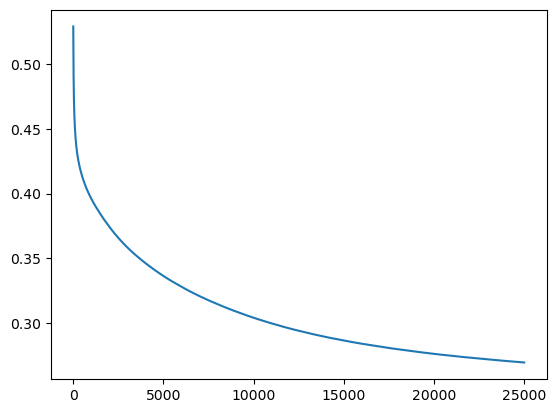

In [14]:
plt.plot(likelihood)

**Sample from the model**

In [15]:
# Generate sequences
for _ in range(12):
    out = []
    context = [1] * block_size
    while True:
        context_tensor = torch.tensor([context]).to(device)
        logits = model(context_tensor)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 1:
            break

    print(''.join(itos[i] for i in out))

madise thoutlast affla layone.
lakerco wish me aman.
lizen.
co one.
the cmoh for nither girls.
scarriage the wress.
our stillet of mattemen wind.
super love wind.
the like a avaan.
the flymer.
stras.
blgam inife.


**Save the final state**

In [17]:
# Save the final state
torch.save(model.state_dict(), 'mlp_parameters.pth')